In [1]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_list=[]
files = os.listdir("C:/Users/pc/Desktop/DiaRet/step2/train_images")
for i in files[::]:
    image = cv2.imread(f"C:/Users/pc/Desktop/DiaRet/step2/train_images/{i}")
    image = cv2.resize(image,(400,400)) 
    image = image[:,:,1]
    kopya = image.copy()
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thold = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
    kenar = cv2.findContours(thold.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    kenar = kenar[0][0]
    kenar = kenar[:,0,:]
    x1 = tuple(kenar[kenar[:,0].argmin()])[0]
    y1 = tuple(kenar[kenar[:,1].argmin()])[1]
    x2 = tuple(kenar[kenar[:,0].argmax()])[0]
    y2 = tuple(kenar[kenar[:,1].argmin()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*4//50
    kopya2 = image.copy()
    if x2-x1 > 100 and y2-y1 > 100:
        kopya2 = kopya2[y1+y:y2-y,x1+x:x2-x]
        kopya2 = cv2.resize(kopya2,(400,400))
    clahe = cv2.createCLAHE(clipLimit = 5.0,tileGridSize=((8,8)))
    cl = clahe.apply(kopya2)
    med_resim = cv2.medianBlur(kopya2,3)
    arka_plan = cv2.medianBlur(kopya2,33)
    maske = cv2.addWeighted(med_resim,1,arka_plan,-1,255)
    maske_resim = cv2.bitwise_and(maske,med_resim)
    img_list.append(maske_resim)
    

In [3]:
df = pd.read_csv("C:/Users/pc/Desktop/DiaRet/step2/train.csv")
print(df["diagnosis"].value_counts())

diagnosis
0    808
1    688
Name: count, dtype: int64


In [4]:
df = pd.read_csv("C:/Users/pc/Desktop/DiaRet/step2/train.csv")
y_train = pd.get_dummies(df["diagnosis"]).values.astype(int)
x_train = np.array(img_list)

In [5]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.15,random_state=42,shuffle = True)

In [6]:
y_train_binary = np.argmax(y_train, axis=1)
y_test_binary = np.argmax(y_test, axis=1)

In [7]:
import numpy as np

x_train = np.repeat(np.expand_dims(x_train, axis=-1), 3, axis=-1)
x_test = np.repeat(np.expand_dims(x_test, axis=-1), 3, axis=-1)

print(x_train.shape)  
print(x_test.shape)  

(1271, 400, 400, 3)
(225, 400, 400, 3)


Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 310s 7s/step - accuracy: 0.5093 - loss: 1.2177 - val_accuracy: 0.5289 - val_loss: 0.8129 - learning_rate: 3.0000e-04
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 294s 7s/step - accuracy: 0.5194 - loss: 1.0574 - val_accuracy: 0.5200 - val_loss: 0.8083 - learning_rate: 3.0000e-04
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 291s 7s/step - accuracy: 0.5161 - loss: 0.9372 - val_accuracy: 0.5333 - val_loss: 0.8034 - learning_rate: 3.0000e-04
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 323s 7s/step - accuracy: 0.5266 - loss: 0.9068 - val_accuracy: 0.5511 - val_loss: 0.7977 - learning_rate: 3.0000e-04
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 293s 7s/step - accuracy: 0.5358 - loss: 0.8669 - val_accuracy: 0.5333 - val_loss: 0.7871 - learning_rate: 3.0000e-04
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 292s 7s/step - accuracy: 0.5350 - loss: 0.8835 - val_accuracy: 0.5378 - val_loss: 0.7857 - learning_rate: 3.0000e-04
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 293s 7s/step - accuracy: 0.5401 

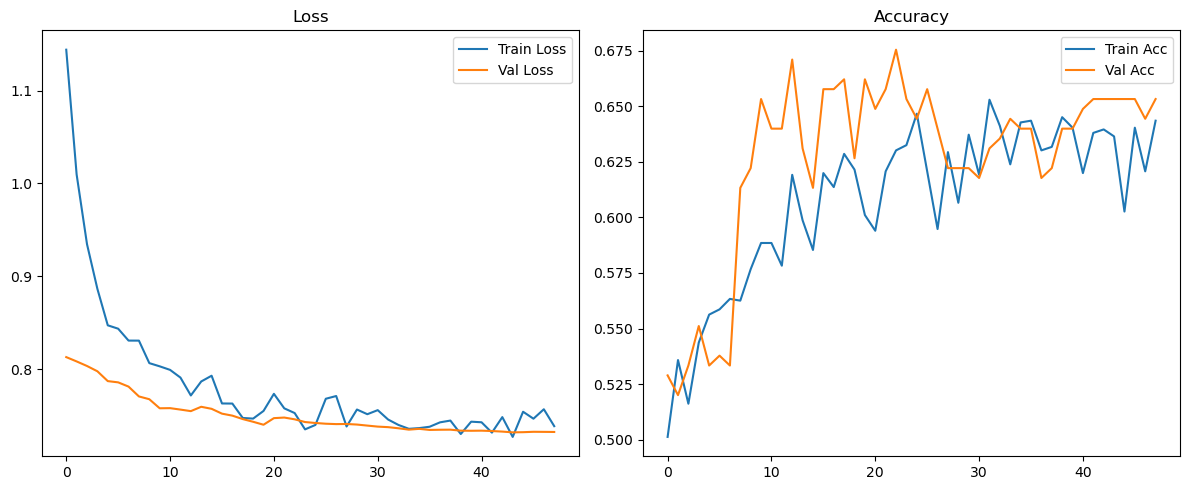

In [22]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.regularizers import l2

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(400, 400, 3))
base_model.trainable = False  

inputs = tf.keras.Input(shape=(400, 400, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.25,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow(x_train, y_train, batch_size=32)
validation_generator = valid_datagen.flow(x_test, y_test, batch_size=32, shuffle=False)

early_stop = EarlyStopping(patience=4, restore_best_weights=True, monitor='val_loss', verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=2, monitor='val_loss', verbose=1, min_lr=1e-6)

history1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

base_model.trainable = True
for layer in base_model.layers[:-80]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

def merge_histories(h1, h2):
    history = {}
    for key in h1.history:
        history[key] = h1.history[key] + h2.history[key]
    return history

full_history = merge_histories(history1, history2)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(full_history['loss'], label='Train Loss')
plt.plot(full_history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(full_history['accuracy'], label='Train Acc')
plt.plot(full_history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.tight_layout()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step
Confusion Matrix:
 [[72 48]
 [30 75]]
Accuracy:     0.6533
Recall:       0.7143 (Sensitivity)
Specificity:  0.6000
Precision:    0.6098
F1 Score:     0.6579
MCC:          0.3150

Classification Report:
              precision    recall  f1-score   support

           0     0.7059    0.6000    0.6486       120
           1     0.6098    0.7143    0.6579       105

    accuracy                         0.6533       225
   macro avg     0.6578    0.6571    0.6533       225
weighted avg     0.6610    0.6533    0.6530       225



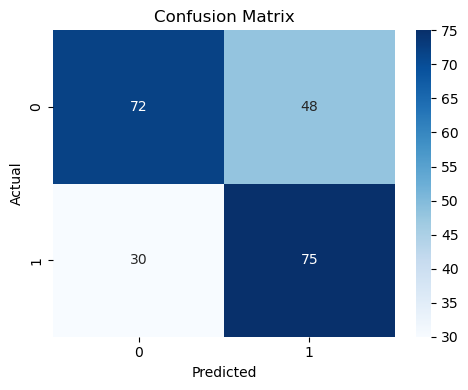

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef
import seaborn as sns

y_pred_proba = model.predict(validation_generator)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_true, y_pred)

print("Confusion Matrix:\n", cm)
print(f"Accuracy:     {accuracy:.4f}")
print(f"Recall:       {recall:.4f} (Sensitivity)")
print(f"Specificity:  {specificity:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"F1 Score:     {f1:.4f}")
print(f"MCC:          {mcc:.4f}")
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


In [25]:
model.save(r"C:\Users\pc\Desktop\DiaRet\step2\step2.keras")
